# Graded Lab: Fine-Tuning Lab

Welcome to the assignment for this module!

Carefully read each Markdown (text) cell, which include instructions and hints. Start by reading the background behind your upcoming tasks.

When you are done, submit your solution by saving it, then clicking on the submit button at the top right side of the page.

## In order for your submission to be graded correctly, you **MUST**:
* **Use the provided variable names**, otherwise the autograder will not be able to locate the variable for grading. 

* **Replace any instances of `None` with your own code.** 

* **Only modify the cells that start with the comment `# GRADED CELL`**.  

* **Use the provided cells for your solution.** You can add new cells to experiment, but these will be omitted when grading. 

To submit your solution, save it, then click on the blue submit button at the top of the page.

<div style="background-color: #FAD888; padding: 10px; border-radius: 3px; box-shadow: 0 2px 4px rgba(0, 0, 0, 0.1); width:95%
">
<strong>Important notes</strong>:

- Code blocks with None will not run properly. If you run them before completing the exercise, you will likely get an error. 

- The notebooks work best in Chrome browser. If you are having problems, please switch to Chrome.

- Make sure you always save before submitting.
</div>

## Introduction

In this lab, you will gain practical experience improving a model through fine-tuning.

You will start with a model that has already been pre-trained on a large corpus of text. Your goal is to improve its performance on math related questions. Your investigation will involve learning how to prepare inputs for a language model. You will then use the HuggingFace library to tune the model, and observe the effect that tuning hyperparameters has on the final model.

## Objectives
* **Embeddings**: Get information from a model's token embeddings.
* **Padding**: Create padded batches for prompts of differing lengths.
* **Explore Appropriate Learning Rates**: Plot loss curves to find an appropriate learning rate for your model.

## Table of Contents

* [Setup](#setup)
* [Tokenization](#tokenization) - Exercise 1
* [Padding](#padding) - Exercise 2
* [HuggingFace Trainer](#hftrainer)
* [Fine-tuning](#supervisedfine-tuning) - Exercise 3, 4

## Setup <a id="setup"></a>

Start by importing all the necessary packages.

In [1]:
import torch
import matplotlib.pyplot as plt

# these two packages are from HuggingFace [https://huggingface.co/]
from transformers import AutoModelForCausalLM, AutoTokenizer, GenerationConfig
from trl import SFTTrainer, SFTConfig
from datasets import load_from_disk

from utils import extract_numerical_answer, plot_train_vs_val

Next you will load the dataset. You will be using the same one from the previous assignment, **GSM8K**. It is already split into train and test sets.

In [2]:
dataset = load_from_disk('/app/data/gsm8k', 'main')
train = dataset['train']
test = dataset['test']

Let's take a look at one of the questions from the dataset using the function below. The function will print the question, its associated answer, and the extracted answer. The `extracted_numerical_anser` function is just like the one you built in the previous lab.

Try looking at a few questions. You can create a new cell and use the function and change the index (`idx`) to see different examples.

In [3]:
def display_data_point(idx):
    example = train[idx]
    print(f'Plaintext Question:\n```\n{example['question']}\n```\n')
    print(f'Plaintext Answer:\n```\n{example['answer']}\n```\n')
    print(f'Extracted Answer:\n```\n{extract_numerical_answer(example['answer'])}\n```\n')

display_data_point(0)

Plaintext Question:
```
Natalia sold clips to 48 of her friends in April, and then she sold half as many clips in May. How many clips did Natalia sell altogether in April and May?
```

Plaintext Answer:
```
Natalia sold 48/2 = <<48/2=24>>24 clips in May.
Natalia sold 48+24 = <<48+24=72>>72 clips altogether in April and May.
#### 72
```

Extracted Answer:
```
72
```



Next, you'll load a language `model` using the `get_model` function. This function initializes both a model and its corresponding tokenizer.

**Key Concepts**
- **Tokenizer**: Processes strings into a format the model can understand
- **Model-specific**: Each tokenizer is unique to its model - they must match!
- **Model choice**: We're using DeepSeek Math base, an open-source 7-billion parameter model specialized for mathematical reasoning

The function returns:
- `model`: The loaded language model ready for inference
- `tokenizer`: The preprocessing tool for converting text to model inputs

> **Note**: This function typically takes around 30 seconds.

In [4]:
def get_model(model_name):
    # Get the tokenizer that corresponds to the model you will use
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    tokenizer.pad_token = tokenizer.pad_token or tokenizer.eos_token

    # Get the model
    model = AutoModelForCausalLM.from_pretrained(model_name, dtype=torch.bfloat16, device_map='auto')

    # Specify beginning of sequence token, end of sequence token, and padding token
    model.generation_config = GenerationConfig.from_pretrained(model_name)
    model.generation_config.pad_token_id = model.generation_config.eos_token_id

    return model, tokenizer

model_name = '/app/models/deepseek-ai/deepseek-math-7b-base'
model, tokenizer = get_model(model_name)

## Tokenization <a id="tokenization"></a>

Strings must be converted into a form suitable for the language model before being passed. The `tokenizer` accomplishes this by taking the string and chunking it up into "tokens". For the DeepSeek model, a token is typically a whole word along with a preceding space. However, longer or less common words may be chunked into multiple tokens.

Each token has an id, and these ids are passed into the model. Note that each model might use a different set of tokens with different ids, so each model needs to use an appropriate tokenizer. That's why you get the tokenizer together with the model, to make sure they fit together.

Run the following cell to see how a standard prompt is tokenized.

In [5]:
def token_table(prompt, tokenizer):
    # Tokenize the prompt
    token_ids = tokenizer.encode(prompt, add_special_tokens=True)

    # Decode each token individually to get its representation
    token_strings = [tokenizer.decode([token_id]) for token_id in token_ids]

    # Create the token table
    column_width = 21
    # Create and print the header
    header = f"{'Token Ids':^{column_width}}" + f"{'Token Strings':^{column_width}}"
    print(header)
    print("=" * len(header))
    # Print the tokens row by row
    for token_id, token_string in zip(token_ids, token_strings):
        # Format token string with quotes
        token_string_quoted = f"'{token_string}'"
        print(f"{token_id:^{column_width}}" + f"{token_string_quoted:^{column_width}}")

prompt = 'The integral of x^2 from 0 to 2 is'
token_table(prompt, tokenizer)

      Token Ids          Token Strings    
       100000        '<｜begin▁of▁sentence｜>'
         549                 'The'        
        12667             ' integral'     
         280                 ' of'        
        1376                 ' x'         
         61                   '^'         
         17                   '2'         
         473                ' from'       
         207                  ' '         
         15                   '0'         
         276                 ' to'        
         207                  ' '         
         17                   '2'         
         317                 ' is'        


You saw how you can use the `tokenizer` to obtain the token ids and the token strings. But how precisely do you pass this into the `model`? You can just invoke the `tokenizer` directly to obtain an object which contains the ids that the `model` will accept and understand. As all neural networks, this model works with numbers and does not need the token strings.

In [6]:
tokenizer(prompt)

{'input_ids': [100000, 549, 12667, 280, 1376, 61, 17, 473, 207, 15, 276, 207, 17, 317], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

Notice how the tokenizer also outputs an `attention_mask`. This is necessary to tell the `model` which tokens to pay attention to (`1`) and which to ignore (`0`). Notice how they are all `1` currently, but you will see an example later when you use padding, where some `0`s appear.

You typically include the following argument `return_tensors='pt'` to specify that you want the data to be represented as tensors instead of Python lists. A tensor is similar to a list, but it stores its data in a way that allow faster computations. It also is able to be put on the AMD GPU for even more speed. The string `'pt'` stands for "PyTorch tensor" because PyTorch is the library used to define the tensors.

In [7]:
tokenizer(prompt, return_tensors='pt')

{'input_ids': tensor([[100000,    549,  12667,    280,   1376,     61,     17,    473,    207,
             15,    276,    207,     17,    317]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])}

You can now pass this into the `model`! The `model.generate(**ids, max_new_tokens=5)` function is used to generate new tokens using a greedy method (picking the highest probability token next). Then the tokenizer decodes the tokens to create a more human-friendly output.

Run the cell below. Does the model answer the question correctly?

In [8]:
def model_output(prompt, model, tokenizer):

    # Using `inference mode` avoids overhead usually required during training
    # The code still works without `inference mode`, but requires more memory
    with torch.inference_mode():
        ids = tokenizer(prompt, return_tensors='pt').to(model.device)

        outputs = model.generate(
            input_ids=ids['input_ids'],
            attention_mask=ids['attention_mask'],
            max_new_tokens=5)
        decoded = tokenizer.decode(outputs[0], skip_special_tokens=True)
        print(f'Model output: {outputs}')
        print(f'Model decoded output: {decoded}\n')

    token_table(decoded, tokenizer)

model_output(prompt, model, tokenizer)

Model output: tensor([[100000,    549,  12667,    280,   1376,     61,     17,    473,    207,
             15,    276,    207,     17,    317,    207,     23,     14,     18,
             13]], device='cuda:0')
Model decoded output: The integral of x^2 from 0 to 2 is 8/3.

      Token Ids          Token Strings    
       100000        '<｜begin▁of▁sentence｜>'
         549                 'The'        
        12667             ' integral'     
         280                 ' of'        
        1376                 ' x'         
         61                   '^'         
         17                   '2'         
         473                ' from'       
         207                  ' '         
         15                   '0'         
         276                 ' to'        
         207                  ' '         
         17                   '2'         
         317                 ' is'        
         207                  ' '         
         23                   '8'  

### Exercise 1: Investigating embedding shape

When you pass a token id to the `model`, it is used to look up a list of numbers (a.k.a. a "vector" or "embedding"). These embeddings are what the model really uses internally as inputs. This is because embeddings are more expressive as inputs than mere ids are, and the model will have an easier time learning.

Below, write code to investigate the number of such embeddings (called "vocab size") that the model has internally as well as the length of each embedding (called "embedding dimension").

The `embeddings` are technically a "layer" of the model. Layers typically have an attribute `.weight` which is the PyTorch tensor you are interested in. PyTorch tensors themselves have a `.shape` attribute which outputs the length of each axis.

For example, if `a` is a PyTorch tensor,
```python
tensor([[1.2,  3.5, -0.8],
        [2.3, -3.1, -1.8]])
```
then `a.shape` will return the tuple `(2, 3)` because there are 2
rows and 3 columns.

Assign the `emb_shape` variable to a tuple representing the shape of the `embedding` layer's weight tensor.

In [20]:
# GRADED CELL: exercise 1

def get_embedding_info(embeddings):
    """
    Get basic information about the model's token embeddings.
    """

    ### START CODE HERE ###
    emb_shape = embeddings.weight.shape
    ### END CODE HERE ###

    vocab_size = emb_shape[0]
    embedding_dim = emb_shape[1]
    
    return vocab_size, embedding_dim

Use the next cell to perform a simple test of your implementation.

In [21]:
# Test the function
vocab_size, embedding_dim = get_embedding_info(model.get_input_embeddings())

# Verification checks
assert vocab_size > 50000, "Vocabulary size of modern models should be over 50,000"
assert embedding_dim > 512, "Embedding dimension of modern models should be over 512"
print(f'Success! The model has {vocab_size:,} tokens, each represented by {embedding_dim}-dimensional vectors')
print(
    'Trivia: This "embedding layer" essentially encodes what list of numbers should represent each token, '
    f'and it was learned during pre-training. It contains {vocab_size * embedding_dim:,} learnable parameters!'
)

Success! The model has 102,400 tokens, each represented by 4096-dimensional vectors
Trivia: This "embedding layer" essentially encodes what list of numbers should represent each token, and it was learned during pre-training. It contains 419,430,400 learnable parameters!


## Padding <a id="padding"></a>

### Exercise 2: Padded batches

When training, you can process multiple inputs at once for efficiency. Text inputs naturally have different lengths, but this is problematic because tensors require all sequences in a batch to have the same length. This is where padding comes in. You can apply a special "padding" token to shorter sequences to make all sequences the same length.

For example, assume you have these sequences of tokens.
```python
              ['The', 'cat', 'in',  'the', 'hat']
                            ['AI',  'is',  'fun']
['Fei', 'Fei', 'Li',  'ran', 'an',  'AI',  'lab']
```
Padding to the longest sequence would produce the following
```python
['PAD', 'PAD', 'The', 'cat', 'in',  'the', 'hat']
['PAD', 'PAD', 'PAD', 'PAD', 'AI',  'is',  'fun']
['Fei', 'Fei', 'Li',  'ran', 'an',  'AI',  'lab']
```

Complete the function below to create a properly padded batch from text prompts of different lengths.

Your are given `prompts` which is a list of prompts of different lengths. You are also given a `tokenizer`.

You previously passed a single prompt to the tokenizer. Now, you can pass the whole list of prompts at once (no loop required). You should invoke the `tokenizer` directly with `tokenizer(prompts, ...)`. There is NO need to call another function like `tokenizer.encode(...)` nor `tokenizer.decode(...)`. Include the argument `return_tensors='pt'` as before, but now also include `padding=True`.

The output of the `tokenizer` will be a dictionary-like object which represents a batch. Get the value for the `'input_ids'` key with `batch['input_ids']`, and assign it to the corresponding variable for the return statement. Do the same for the `'attention_mask'` key.

In [22]:
# GRADED CELL: exercise 2

def create_padded_batch(prompts, tokenizer):
    """
    Create a padded batch from prompts of different lengths by passing the prompts to the tokenizer.
    """

    input_ids = torch.tensor(0)
    attention_mask = torch.tensor(0)

    ### START CODE HERE ###
    batch = tokenizer(prompts, return_tensors='pt', padding=True)
    input_ids = batch['input_ids']
    attention_mask = batch['attention_mask']
    ### END CODE HERE ###
    
    return input_ids, attention_mask

In [23]:
# Test the function
test_prompts = [
    "What is 2+2?",
    "Calculate the derivative of x^3 + 2x^2 - 5x + 7 with respect to x",
    "Find the integral of sin(x)cos(x)dx"
]

input_ids, attention_mask = create_padded_batch(test_prompts, tokenizer)

# Check the results
assert len(input_ids.shape) == 2, 'Tensors should be 2-dimensional (with first axis being the batch dimension)'
assert input_ids.shape == attention_mask.shape, 'input_ids and attention_mask should have the same shape'
assert input_ids.dtype == attention_mask.dtype == torch.int64
assert input_ids.shape[0] == len(test_prompts), 'Batch size should match number of test prompts'
assert input_ids.shape[1] == max(len(tokenizer.encode(s, add_special_tokens=True)) for s in test_prompts), f'Padding should be to the longest sequence'
assert torch.all((0 <= input_ids) & (input_ids <= model.get_input_embeddings().weight.shape[0])), f'Some ids in `input_ids` are invalid'
assert torch.all((attention_mask == 0) | (attention_mask == 1)), 'Attention mask should only contain 0s and 1s'
print(f'Success! Created batch with shape: {input_ids.shape}')
print(f'Padding token ID used: {tokenizer.pad_token_id}\n')
print(f'{input_ids = }')
print(f'{attention_mask = }')

Success! Created batch with shape: torch.Size([3, 25])
Padding token ID used: 100001

input_ids = tensor([[100001, 100001, 100001, 100001, 100001, 100001, 100001, 100001, 100001,
         100001, 100001, 100001, 100001, 100001, 100001, 100001, 100001, 100000,
           2640,    317,    207,     17,     10,     17,     30],
        [100000,  72001,    254,  19533,    280,   1376,     61,     18,    919,
            207,     17,     87,     61,     17,    570,    207,     20,     87,
            919,    207,     22,    366,   2650,    276,   1376],
        [100001, 100001, 100001, 100001, 100001, 100001, 100001, 100001, 100001,
         100001, 100001, 100000,  12971,    254,  12667,    280,   6198,      7,
             87,      8,   6281,      7,     87,      8,  12227]])
attention_mask = tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1,
         1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1],
        [0, 

## HuggingFace Trainer <a id="hftrainer"></a>

The code here sets up a fine-tuning pipeline that teaches the `model` to answer questions. Many of the details of tokenization and padding are handled internally by the framework. Also, the trainer object will be responsible for looping over the data, computing a loss from the model, backpropagating, and repeating.

The `get_trainer()` function returns the `SFTTrainer()`, which you have learned about in the videos and takes care of the supervised Fine-Tuning. This abstraction is made to simplify your code later on. Note that the `completion_only_loss` is set to `True` within the `SFTConfig()`, which makes sure that the loss is only calculated on the outputs, but not on the inputs.

In [24]:
def get_trainer(model_name, learning_rate, weight_decay=0.01, num_train_epochs=3, train_set_size=200, eval_set_size=20):
    batch_size = 20
    train_dataset = train.select(range(train_set_size)).rename_columns({
        'question': 'prompt', 
        'answer': 'completion'
    })
    eval_dataset = test.select(range(eval_set_size)).rename_columns({
        'question': 'prompt', 
        'answer': 'completion'
    })

    training_args = SFTConfig(
        # Logging
        output_dir=None,
        logging_dir=None,
        logging_strategy='steps',
        logging_steps=1,
        eval_strategy='steps',
        eval_steps=1,
        save_strategy='no',
        report_to='none',
        # Hyperparameters
        learning_rate=learning_rate,
        weight_decay=weight_decay,
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=batch_size,
        num_train_epochs=num_train_epochs,
        # Dataset
        completion_only_loss=True,
    )

    return SFTTrainer(
        model=model_name,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=eval_dataset,
    )

## Fine-Tuning <a id="supervisedfine-tuning"></a>

Get the trainer with chosen hyperparameters, call the trainer which loops over your dataset to tune your model, and then plot the loss curves. Loss is a measure of how badly the model does, so the lower the better.

> **Note**: The cell typically takes around 60 seconds to run.

Adding EOS to train dataset:   0%|          | 0/200 [00:00<?, ? examples/s]

Tokenizing train dataset:   0%|          | 0/200 [00:00<?, ? examples/s]

Truncating train dataset:   0%|          | 0/200 [00:00<?, ? examples/s]

Adding EOS to eval dataset:   0%|          | 0/20 [00:00<?, ? examples/s]

Tokenizing eval dataset:   0%|          | 0/20 [00:00<?, ? examples/s]

Truncating eval dataset:   0%|          | 0/20 [00:00<?, ? examples/s]

Step,Training Loss,Validation Loss,Entropy,Num Tokens,Mean Token Accuracy
1,1.069300,0.999759,1.237676,3478.000000,0.773733
2,1.030400,0.997764,1.236412,7674.000000,0.772712
3,1.076100,0.994375,1.235509,11199.000000,0.776114
4,1.132300,0.994385,1.234208,14693.000000,0.775434
5,1.023000,0.990852,1.234822,18798.000000,0.774413
6,1.026300,0.989397,1.234491,22534.000000,0.774753
7,1.018300,0.987905,1.234279,26513.000000,0.774073
8,1.007600,0.987825,1.234983,30698.000000,0.774413
9,1.135600,0.987543,1.232935,34325.000000,0.775774
10,0.943800,0.986376,1.233449,38180.000000,0.774753


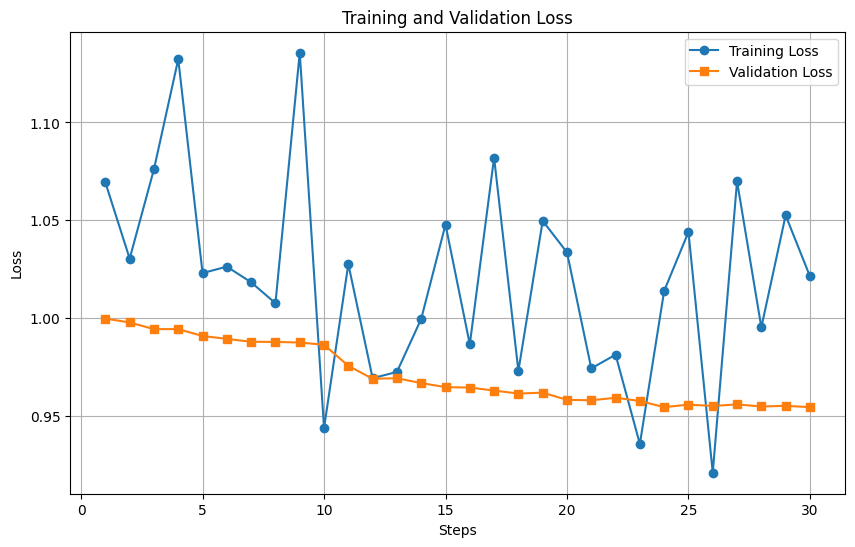

Training losses: [1.0693, 1.0304, 1.0761, 1.1323, 1.023, 1.0263, 1.0183, 1.0076, 1.1356, 0.9438, 1.0276, 0.9693, 0.9725, 0.9996, 1.0478, 0.9866, 1.082, 0.973, 1.0497, 1.0336, 0.9743, 0.9813, 0.9357, 1.0139, 1.044, 0.921, 1.0699, 0.9953, 1.0525, 1.0214]
Validation losses: [0.9997590780258179, 0.997763991355896, 0.9943752288818359, 0.9943848848342896, 0.9908522367477417, 0.9893972277641296, 0.9879053235054016, 0.9878247380256653, 0.9875428080558777, 0.986375629901886, 0.9756172299385071, 0.9690111875534058, 0.9692727327346802, 0.9668139219284058, 0.9647243618965149, 0.964519202709198, 0.9629729986190796, 0.9614537358283997, 0.9619038701057434, 0.9582379460334778, 0.9580134153366089, 0.9592955708503723, 0.9576628804206848, 0.954491913318634, 0.9558082818984985, 0.9551113247871399, 0.9559004902839661, 0.9548410177230835, 0.955163300037384, 0.9545077085494995]


In [25]:
trainer = get_trainer(model_name, learning_rate=9e-7)
trainer.train()
plot_train_vs_val(trainer.state.log_history)

The `model` is not doing very well! Notice that the loss hardly descends at all for the validation loss. The training loss seems a bit more erratic but it is also hardly descending at all. This slow descent is a sign that the learning rate is too low.

### Exercise 3: Finding a good learning rate

Your goal is to tune the learning rate so that the loss curve descends faster. The curve below is the kind of curve you are going for!

![Good Plot](good-plot-loss.png)

Your task is to assign the `learning_rate_ex3` variable to an appropriate value. Afterwards, the cell creates a trainer, performs training, and plots. Try different learning rates to see what results you get, and choose the learning rate that produces a good loss curve.

> **Note**: The cell typically takes around 60 seconds to run.

In [33]:
# GRADED CELL: exercise 3

# Hint: Your learning rate needs to be higher than what you have seen above.
### START CODE HERE ###
learning_rate_ex3 = 9e-6
### END CODE HERE ###

Adding EOS to train dataset:   0%|          | 0/200 [00:00<?, ? examples/s]

Tokenizing train dataset:   0%|          | 0/200 [00:00<?, ? examples/s]

Truncating train dataset:   0%|          | 0/200 [00:00<?, ? examples/s]

Adding EOS to eval dataset:   0%|          | 0/20 [00:00<?, ? examples/s]

Tokenizing eval dataset:   0%|          | 0/20 [00:00<?, ? examples/s]

Truncating eval dataset:   0%|          | 0/20 [00:00<?, ? examples/s]

Step,Training Loss,Validation Loss,Entropy,Num Tokens,Mean Token Accuracy
1,1.069300,0.964532,1.229489,3478.000000,0.778836
2,0.992200,0.887870,1.209117,7674.000000,0.789724
3,0.954500,0.860473,1.198461,11199.000000,0.792446
4,0.974300,0.720309,1.135549,14693.000000,0.819667
5,0.736400,0.679768,1.105813,18798.000000,0.826131
6,0.675700,0.645664,1.064999,22534.000000,0.832596
7,0.636200,0.621949,1.039072,26513.000000,0.838721
8,0.628300,0.573586,0.992909,30698.000000,0.841783
9,0.615100,0.523539,0.960283,34325.000000,0.847567
10,0.420800,0.506817,0.947550,38180.000000,0.849949


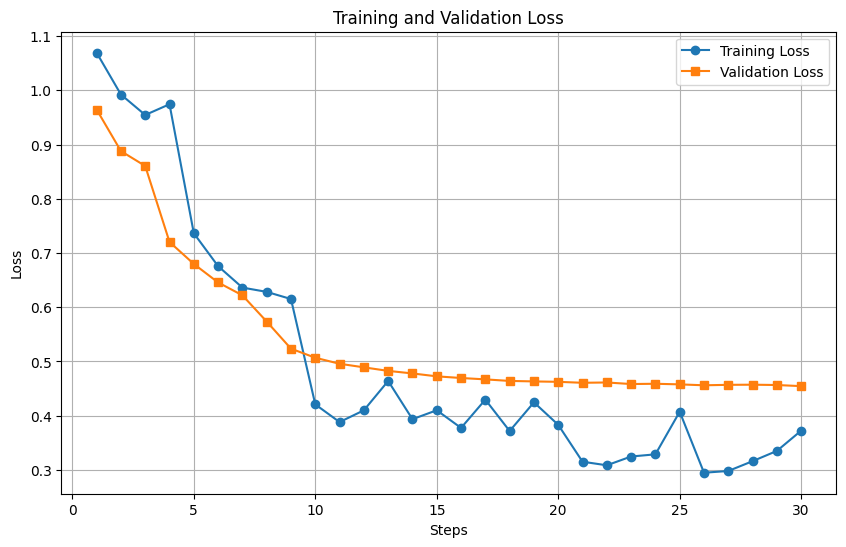

Training losses: [1.0693, 0.9922, 0.9545, 0.9743, 0.7364, 0.6757, 0.6362, 0.6283, 0.6151, 0.4208, 0.3882, 0.4099, 0.464, 0.3935, 0.41, 0.3774, 0.4296, 0.3717, 0.4246, 0.3831, 0.3151, 0.3085, 0.3247, 0.3287, 0.4073, 0.2948, 0.298, 0.3161, 0.335, 0.3724]
Validation losses: [0.9645315408706665, 0.8878704905509949, 0.8604726791381836, 0.7203093767166138, 0.6797683238983154, 0.645664393901825, 0.6219490766525269, 0.5735855102539062, 0.5235393047332764, 0.506816565990448, 0.49572476744651794, 0.4891255497932434, 0.48258090019226074, 0.47788333892822266, 0.47253116965293884, 0.4694685935974121, 0.46693482995033264, 0.4640716016292572, 0.4631664752960205, 0.4624119699001312, 0.4606425166130066, 0.46121764183044434, 0.4583369791507721, 0.45884132385253906, 0.45771390199661255, 0.45602473616600037, 0.45687422156333923, 0.4571259617805481, 0.45653462409973145, 0.4544631838798523]


In [34]:
trainer = get_trainer(model_name, learning_rate=learning_rate_ex3)
trainer.train()
plot_train_vs_val(trainer.state.log_history)

In [35]:
assert 3e-6 <= trainer.args.learning_rate <= 1e-5
print()
print(f'Success! You have found an appropriate range for the learning rate.')


Success! You have found an appropriate range for the learning rate.


### Exercise 4: Finding a learning rate that's too high!

You've seen an example of the learning rate being too low and another example of it being tuned correctly. Now try to tune the learning rate too high by assigning `learning_rate_ex4` and see what effect this has on the loss.

> **Note**: The cell typically takes around 60 seconds to run.

In [36]:
# GRADED CELL: exercise 4

### START CODE HERE ###
learning_rate_ex4 = 0.001
### END CODE HERE ###

Adding EOS to train dataset:   0%|          | 0/200 [00:00<?, ? examples/s]

Tokenizing train dataset:   0%|          | 0/200 [00:00<?, ? examples/s]

Truncating train dataset:   0%|          | 0/200 [00:00<?, ? examples/s]

Adding EOS to eval dataset:   0%|          | 0/20 [00:00<?, ? examples/s]

Tokenizing eval dataset:   0%|          | 0/20 [00:00<?, ? examples/s]

Truncating eval dataset:   0%|          | 0/20 [00:00<?, ? examples/s]

Step,Training Loss,Validation Loss,Entropy,Num Tokens,Mean Token Accuracy
1,1.069300,14.491300,1.186980,3478.000000,0.063287
2,14.434800,8.665892,2.302768,7674.000000,0.063627
3,8.462900,17.110222,5.306585,11199.000000,0.000340
4,17.276000,9.794867,1.689565,14693.000000,0.051038
5,9.443200,11.722170,3.746660,18798.000000,0.026880
6,11.832700,7.202113,3.993312,22534.000000,0.028241
7,6.990000,8.016516,5.804834,26513.000000,0.009527
8,8.081800,7.775851,2.517003,30698.000000,0.049337
9,7.611100,7.001173,2.788719,34325.000000,0.028921
10,7.151500,6.226912,4.769859,38180.000000,0.025859


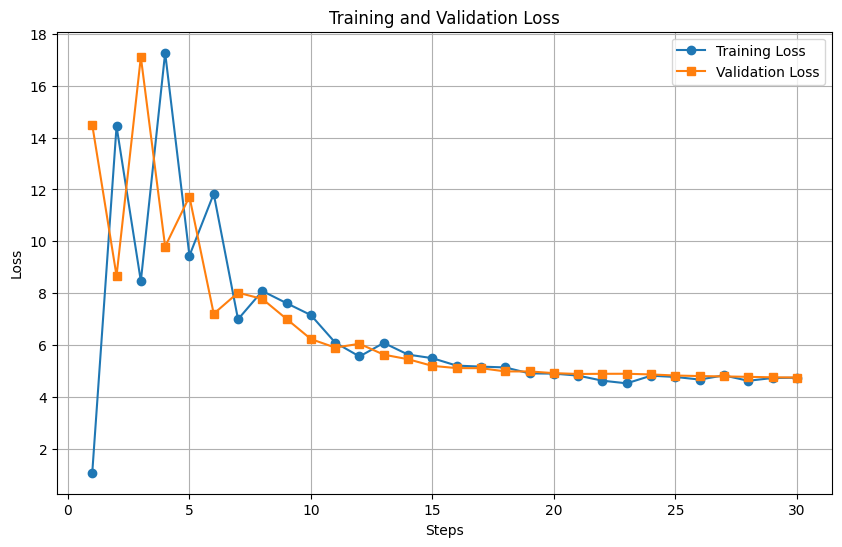

Training losses: [1.0693, 14.4348, 8.4629, 17.276, 9.4432, 11.8327, 6.99, 8.0818, 7.6111, 7.1515, 6.0907, 5.5544, 6.0785, 5.6267, 5.4894, 5.2022, 5.1637, 5.1326, 4.9019, 4.8938, 4.8163, 4.621, 4.5183, 4.8131, 4.7651, 4.6642, 4.825, 4.6166, 4.7241, 4.736]
Validation losses: [14.491299629211426, 8.665891647338867, 17.11022186279297, 9.794866561889648, 11.722169876098633, 7.202112674713135, 8.016515731811523, 7.775851249694824, 7.0011725425720215, 6.226912498474121, 5.89794921875, 6.044653415679932, 5.624722480773926, 5.448919296264648, 5.191926956176758, 5.106728553771973, 5.103013515472412, 4.978457450866699, 4.977310657501221, 4.911955833435059, 4.879532337188721, 4.886152744293213, 4.887899398803711, 4.8618669509887695, 4.820215225219727, 4.798651695251465, 4.7852888107299805, 4.7689738273620605, 4.751036643981934, 4.7424821853637695]


In [37]:
trainer = get_trainer(model_name, learning_rate=learning_rate_ex4)
trainer.train()
plot_train_vs_val(trainer.state.log_history)

In [38]:
assert 9e-5 <= trainer.args.learning_rate
print()
print(f'Success! You have found a learning rate that was too large.')


Success! You have found a learning rate that was too large.


Congratulations! You've succesfully completed the SFT lab!